In [1]:
import seaborn as sns
from alphaanalysis.plot.gam import get_sig_intervals
from matplotlib import pyplot as plt

# Data Base

In [ ]:
%%capture

from djimaging.user.alpha.schemas.alpha_schema import *
from djimaging.user.alpha.utils import database

indicator = 'calcium'
database.connect_dj(indicator=indicator)

# Data Frame

In [3]:
roi_tab = database.get_roi_tab(quality_filter=True)

chirp_tab = (
    SineSpotSurroundIndex.proj(lg_surround_index='sinespot_surround_index') * 
    FieldPosMetrics.RoiPosMetrics.proj(soma_dist='d_dist_to_soma') *
    RetinalFieldLocationWing.proj(group="wing_side")
) & roi_tab.proj()

df = chirp_tab.fetch(format='frame')
df = df.reset_index()
df = df.sample(frac=1)

In [4]:
import utils

df = utils.prep_df(df)
df

,experimenter,date,exp_num,field,cond1,roi_id,lg_surround_index,soma_dist,group,cell_id,field_id
199,Ran,2020-05-11,2,d3,control,8,-0.338886,153.9430,t,2020-05-11_2,2020-05-11_2_d3
455,Ran,2020-07-08,1,d6,control,2,-0.582661,149.0870,n,2020-07-08_1,2020-07-08_1_d6
148,Ran,2020-05-11,1,d6,control,3,-0.881395,34.7525,t,2020-05-11_1,2020-05-11_1_d6
262,Ran,2020-06-08,1,d4,control,3,0.790041,174.2460,n,2020-06-08_1,2020-06-08_1_d4
122,Ran,2020-05-11,1,d3,control,10,-0.233621,129.8270,t,2020-05-11_1,2020-05-11_1_d3
...,...,...,...,...,...,...,...,...,...,...,...
514,Ran,2020-07-13,1,d5,control,6,-0.729586,149.5350,t,2020-07-13_1,2020-07-13_1_d5
756,Ran,2020-08-31,1,d6,control,13,0.903293,123.7870,n,2020-08-31_1,2020-08-31_1_d6
138,Ran,2020-05-11,1,d5,control,3,-2.540590,96.9783,t,2020-05-11_1,2020-05-11_1_d5
568,Ran,2020-08-23,1,d4,control,5,-1.040500,109.7310,t,2020-08-23_1,2020-08-23_1_d4


# Plot

In [5]:
from alphaanalysis import plot as plota
plota.set_rc_params()

In [6]:
order = plota.get_order(indicator=indicator)
palette = plota.get_palette(indicator=indicator)
colors = [palette[group] for group in order]

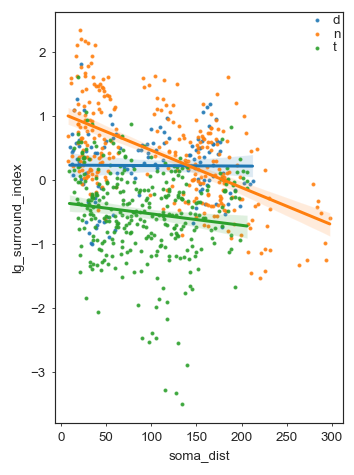

In [7]:
utils.plot_scatter_metrics(df, ['lg_surround_index'], groupby='group')

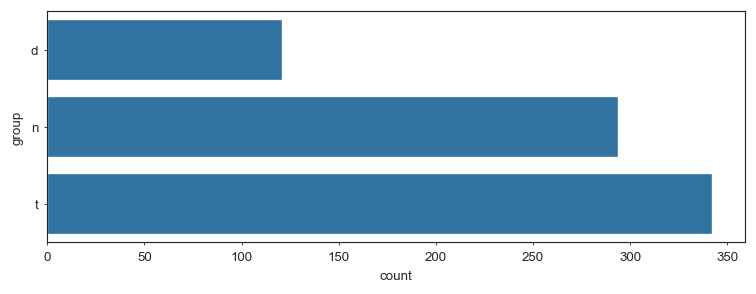

In [8]:
sns.countplot(data=df, y="group");

# Fit GAM

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R
#noqa

rm(list=ls()) 

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


## R imports

In [11]:
%%R
#noqa

library("IRdisplay")
library("dplyr")
library('parallel')
library('ggplot2')
library("nlme")
library("mgcv")
library("ggthemes")
library("itsadug")
library("png")
library("xtable")
library("tidymv")
library("cowplot")
library("qgam")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.
Loading required package: plotfunctions

Attaching package: ‘plotfunctions’

The following object is masked from ‘package:ggplot2’:

    alpha

Loaded package itsadug 2.4 (see 'help("itsadug")' ).

Attaching package: ‘xtable’

The following object is masked from ‘package:IRdisplay’:

    display

tidymv has been superseded by tidygam. The package tidymv is no longer maintained but will be
    kept on CRAN to ensure reproducibility of older analyses. Users should
    use the replacement package tidygam for new analyses, which is available on
    CRAN and GitHub (https://github.com/stefanocoretta/tidygam).

Attaching package: ‘tidymv’

Th

# Import R df

In [12]:
%%R -i df
#noqa

df$group <- factor(df$group)
df$cell_id <- factor(df$cell_id)
df$field_id <- factor(df$field_id)

df <- df[df$soma_dist <= 200, ]

head(df)

    experimenter   date exp_num field   cond1 roi_id lg_surround_index
199          Ran 737556       2    d3 control      8         -0.338886
455          Ran 737614       1    d6 control      2         -0.582661
148          Ran 737556       1    d6 control      3         -0.881395
262          Ran 737584       1    d4 control      3          0.790041
122          Ran 737556       1    d3 control     10         -0.233621
536          Ran 737660       1    d1 control      1          0.710608
    soma_dist group      cell_id        field_id
199  153.9430     t 2020-05-11_2 2020-05-11_2_d3
455  149.0870     n 2020-07-08_1 2020-07-08_1_d6
148   34.7525     t 2020-05-11_1 2020-05-11_1_d6
262  174.2460     n 2020-06-08_1 2020-06-08_1_d4
122  129.8270     t 2020-05-11_1 2020-05-11_1_d3
536   18.7469     t 2020-08-23_1 2020-08-23_1_d1


## Helper functions

In [13]:
%%R
#noqa

display_model <- function(m){
    print(summary(m));
    tabs <- capture.output(gamtabs(m, type="HTML"));
    display_html(tabs);
}

## Plot raw data

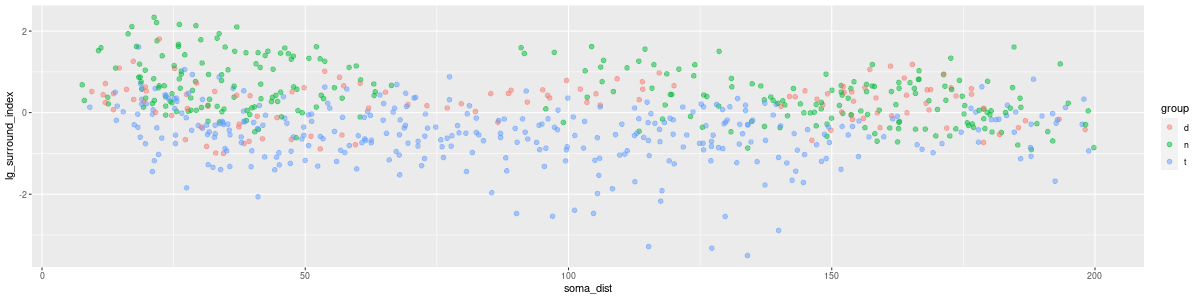

In [14]:
%%R -w 1200 -h 300
#noqa

p1 <- ggplot(aes(x=soma_dist, y=lg_surround_index, color=group), data=df)  +
    geom_point(alpha=.5, size=2)
    
plot(plot_grid(p1, ncol=1))

# GAMs

## response_lg_surround lower

In [15]:
%%R
#noqa

m1a_lg <- gam(lg_surround_index ~ group + s(soma_dist, k=8, bs="cr"), data=df)
m2a_lg <- gam(lg_surround_index ~ group + s(soma_dist, by=group, k=8, bs="cr"), data=df)
m3a_lg <- gam(lg_surround_index ~ group + s(soma_dist, by=group, k=8, bs="cr") + s(cell_id, bs="re"), data=df)
m3b_lg <- gam(lg_surround_index ~ group + s(soma_dist, by=group, k=8, bs="cr") + s(cell_id, bs="re"), data=df, family=scat)
m4a_lg <- gam(lg_surround_index ~ group + s(soma_dist, by=group, k=12, bs="cr") + s(cell_id, bs="re"), data=df)
m4b_lg <- gam(lg_surround_index ~ group + s(soma_dist, by=group, k=12, bs="cr") + s(cell_id, bs="re"), data=df, family=scat)
m5a_lg <- gam(lg_surround_index ~ group + s(soma_dist, by=group, k=16, bs="cr") + s(cell_id, bs="re"), data=df)
m5b_lg <- gam(lg_surround_index ~ group + s(soma_dist, by=group, k=16, bs="cr") + s(cell_id, bs="re"), data=df, family=scat)

In [16]:
%%R
#noqa
BIC(m1a_lg, m2a_lg, m3a_lg, m3b_lg, m4a_lg, m4b_lg, m5a_lg, m5b_lg)

              df      BIC
m1a_lg  8.559376 1465.605
m2a_lg 18.062003 1463.359
m3a_lg 26.638694 1331.342
m3b_lg 24.871436 1312.746
m4a_lg 31.374020 1343.689
m4b_lg 28.621471 1322.011
m5a_lg 27.165137 1323.089
m5b_lg 28.776683 1324.044


In [17]:
%%R
#noqa
anova(m1a_lg, m2a_lg, m3a_lg, m4a_lg, m5a_lg, test="F")

Analysis of Deviance Table

Model 1: lg_surround_index ~ group + s(soma_dist, k = 8, bs = "cr")
Model 2: lg_surround_index ~ group + s(soma_dist, by = group, k = 8, bs = "cr")
Model 3: lg_surround_index ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")
Model 4: lg_surround_index ~ group + s(soma_dist, by = group, k = 12, 
    bs = "cr") + s(cell_id, bs = "re")
Model 5: lg_surround_index ~ group + s(soma_dist, by = group, k = 16, 
    bs = "cr") + s(cell_id, bs = "re")
  Resid. Df Resid. Dev      Df Deviance       F    Pr(>F)    
1    710.57     298.89                                       
2    699.41     273.15 11.1656   25.741  7.7538  7.01e-13 ***
3    690.45     210.17  8.9605   62.974 23.6367 < 2.2e-16 ***
4    684.78     204.75  5.6618    5.425  3.2223  0.004789 ** 
5    689.71     206.78 -4.9275   -2.027  1.3839  0.228920    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Family: Scaled t(7.924,0.48) 
Link function: identity 

Formula:
lg_surround_index ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)   0.0766     0.2653   0.289   0.7728  
groupn        0.3758     0.3066   1.226   0.2203  
groupt       -0.6082     0.3064  -1.985   0.0471 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df  Chi.sq p-value    
s(soma_dist):groupd  3.068  3.792   4.223   0.242    
s(soma_dist):groupn  1.001  1.002  81.221  <2e-16 ***
s(soma_dist):groupt  3.373  4.108  42.073  <2e-16 ***
s(cell_id)          10.480 11.000 226.049  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.55   Deviance explained = 48.3%
-REML = 615.04  Scale est. = 1         n = 719

Method: REML   Optimizer: outer newton
full convergence aft

In addition: Warning message:
In getOption("jupyter.base_display_func")(data, metadata) :
  IRdisplay can only be used from the IPython R kernel and R magic.


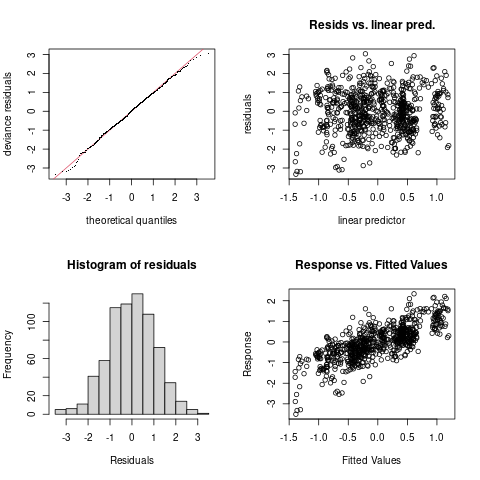

In [18]:
%%R
#noqa
m_lg <- m3b_lg
display_model(m_lg)
gam.check(m_lg)

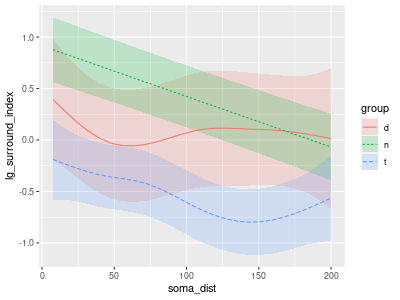

In [19]:
%%R -w 400 -h 300
#noqa

p1 <- plot_smooths(model=m_lg, series=soma_dist, comparison=group)
plot(p1, ylim=c(0, 60))

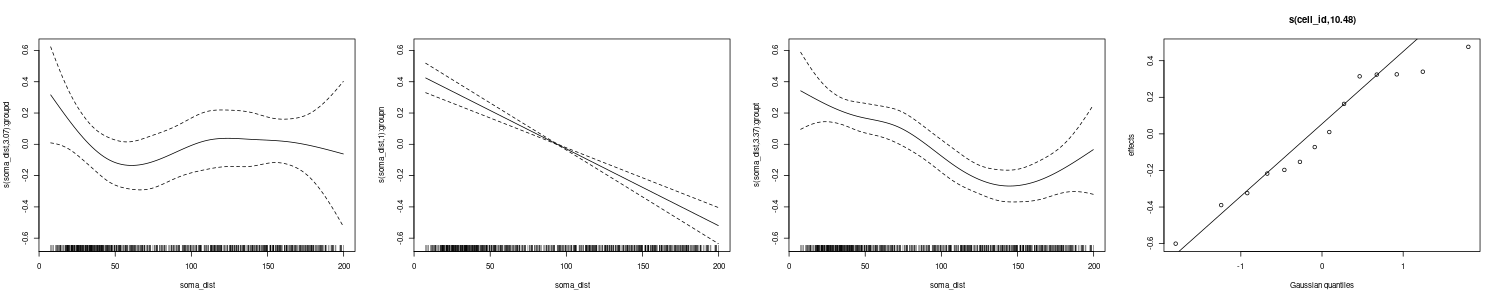

In [20]:
%%R -w 1500 -h 300
#noqa

par(mfrow = c(1,4))
plot(m_lg)

### Plot fits

In [21]:
%%R
#noqa

r_df_pred_lg = predict_gam(m_lg, exclude_terms=s(cell_id, bs="re"))
head(r_df_pred_lg)

# A tibble: 6 × 5
  group soma_dist cell_id         fit se.fit
  <fct>     <dbl> <fct>         <dbl>  <dbl>
1 d          7.62 2020-05-10_1  0.393  0.303
2 n          7.62 2020-05-10_1  0.877  0.160
3 t          7.62 2020-05-10_1 -0.190  0.199
4 d         11.5  2020-05-10_1  0.339  0.292
5 n         11.5  2020-05-10_1  0.857  0.160
6 t         11.5  2020-05-10_1 -0.211  0.187


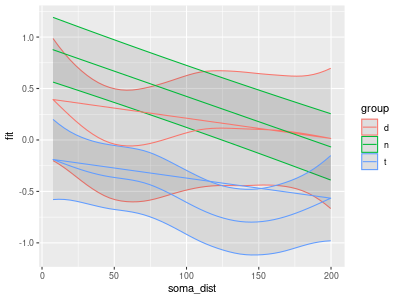

In [22]:
%%R -w 400 -h 300
#noqa

predict_gam(m_lg, exclude_terms=s(cell_id, bs="re")) %>%
    ggplot(aes(soma_dist, fit, col=group)) +
    geom_smooth_ci()

### Plot differences 

[1] 2.39398
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 7.623390 to 199.793000. 
	* cell_id : factor; set to the value(s): 2020-05-10_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns are canceled: s(cell_id)
 

Difference is not significant.
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 7.623390 to 199.793000. 
	* cell_id : factor; set to the value(s): 2020-05-10_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns are canceled: s(cell_id)
 

soma_dist window(s) of significant difference(s):
	7.623390 - 190.087464
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 7.623390 to 199.793000. 
	* cell_id : factor; set to the value(s): 2020-05-10_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns are canceled: s(cell_id)
 

soma_dist window(s) of significant differenc

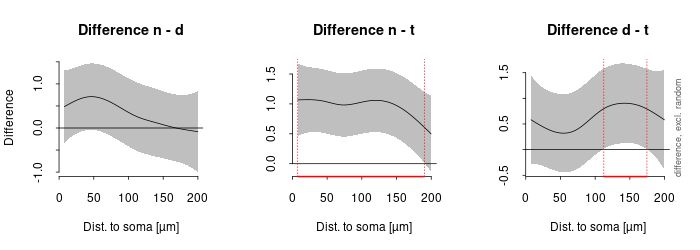

In [23]:
%%R -w 700 -h 250 -o nd_diff_lg -o nt_diff_lg -o dt_diff_lg
#noqa

n_diffs <- 3
par(mfrow=c(1, n_diffs), cex=1.0, tcl=-0.2)

se <- qnorm((100 - (2.5/n_diffs))/100)
print(se)
ylim <- NULL #c(-150, 150)
ylab <- 'Difference'
xlab <- 'Dist. to soma [µm]'

nd_diff_lg <- plot_diff(m_lg, view="soma_dist", comp=list(group=c("n", "d")), se=se, ylab=ylab, xlab=xlab, ylim=ylim, hide.label=TRUE)
nt_diff_lg <- plot_diff(m_lg, view="soma_dist", comp=list(group=c("n", "t")), se=se, ylab='', xlab=xlab, ylim=ylim, hide.label=TRUE)
dt_diff_lg <- plot_diff(m_lg, view="soma_dist", comp=list(group=c("d", "t")), se=se, ylab='', xlab=xlab, ylim=ylim)

In [24]:
pairs_sig_regions_lg = [
    ("n vs. d", get_sig_intervals(nd_diff_lg)),
    ("n vs. t", get_sig_intervals(nt_diff_lg)),
    ("d vs. t", get_sig_intervals(dt_diff_lg)),
]
pairs_sig_regions_lg

[]
[]
[ 0 94]
[]
[53 86]
[]


[('n vs. d', []),
 ('n vs. t', [(7.62339, 190.08746414141413)]),
 ('d vs. t', [(110.5020701010101, 174.55860676767676)])]

# Go back to python for easy plotting

In [25]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
    df_pred_lg = ro.conversion.rpy2py(ro.globalenv['r_df_pred_lg'])

(2.5, 2.0)


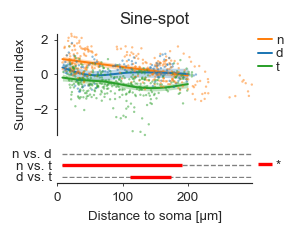

In [26]:
fig, axs = utils.plot_fits(
    df=df,
    df_preds=[df_pred_lg],
    pairs_sig_regions_list=[pairs_sig_regions_lg],
    titles=[None],
    ys=['lg_surround_index'],
    ylabels=['Surround index'],
    x='soma_dist',
    xlabel='Distance to soma [µm]',
    order=order, colors=colors,
    figsize=(2.5, 2.0), ms=2, ma=0.5
)

axs[0].set_title("Sine-spot")
plt.tight_layout()

plt.savefig(f'figures/{indicator}_soma_dist_sinespot_surround.pdf')
plt.show()